In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import numpy as np
import torch
from PIL import Image
from transformers import AutoModelForVision2Seq, AutoProcessor
import json

import os
from collections import deque
from dataclasses import dataclass
from pathlib import Path
from typing import Optional

# Added from mujoco
from dm_control import viewer
from dm_control.composer import Environment
import matplotlib.pyplot as plt
from mujoco_sim.environments.tasks.robot_push_button import RobotPushButtonTask
from PIL import Image
import cv2
import json
import numpy as np
import dm_env

import draccus
import torch
import torch.distributed as dist
import tqdm
from accelerate import PartialState
from peft import LoraConfig, PeftModel, get_peft_model, prepare_model_for_kbit_training
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import AutoModelForVision2Seq, AutoProcessor, BitsAndBytesConfig
from transformers import AutoConfig, AutoImageProcessor
from transformers.modeling_outputs import CausalLMOutputWithPast

from prismatic.models.backbones.llm.prompting import PurePromptBuilder, VicunaV15ChatPromptBuilder
from prismatic.util.data_utils import PaddedCollatorForActionPrediction
from prismatic.vla.action_tokenizer import ActionTokenizer
from prismatic.vla.datasets import RLDSBatchTransform, RLDSDataset
from prismatic.vla.datasets.rlds.utils.data_utils import save_dataset_statistics

from prismatic.extern.hf.configuration_prismatic import OpenVLAConfig
from prismatic.extern.hf.modeling_prismatic import OpenVLAForActionPrediction
from prismatic.extern.hf.processing_prismatic import PrismaticImageProcessor, PrismaticProcessor

/fast_storage/qnoens/conda/openvla/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-28 10:38:01.812534: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-28 10:38:01.832137: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-28 10:38:01.832161: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-28 10:38

In [3]:
# Load the model and processor
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

open_vla_weights_path = '/fast_storage/qnoens/OpenVLA/training/log/openvla-7b+pushbutton_mujoco_rlds+b16+lr-0.0005+lora-r32+dropout-0.0'
run_dir = '/fast_storage/qnoens/OpenVLA/training/log/openvla-7b+pushbutton_mujoco_rlds+b16+lr-0.0005+lora-r32+dropout-0.0'

processor = AutoProcessor.from_pretrained(open_vla_weights_path, trust_remote_code=True)
vla = AutoModelForVision2Seq.from_pretrained(open_vla_weights_path, trust_remote_code=True, torch_dtype=torch.bfloat16, low_cpu_mem_usage=True).to(device)

<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead
<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead
<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead
<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead
Loading checkpoint shards: 100%|██████████| 4/4 [00:00<00:00,  4.41it/s]


In [4]:
# Define data statistics
dataset_statistics_path = os.path.join(run_dir, "dataset_statistics.json")
print(dataset_statistics_path, os.path.isfile(dataset_statistics_path))
if os.path.isfile(dataset_statistics_path):
    with open(dataset_statistics_path, "r") as f:
        norm_stats = json.load(f)
    vla.norm_stats = norm_stats

/fast_storage/qnoens/OpenVLA/training/log/openvla-7b+pushbutton_mujoco_rlds+b16+lr-0.0005+lora-r32+dropout-0.0/dataset_statistics.json True


[ 0.05        0.02517765  0.00057179 -0.0044919  -0.00230637 -0.00104079
  0.        ]


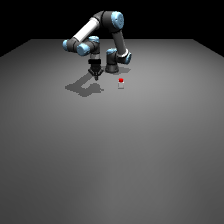

In [5]:
import pandas as pd
import PIL
import io

# Load the dataset
df = pd.read_parquet('episode_000000.parquet', engine='pyarrow')

step = 5
print(df.loc[step, 'action'])

image_dict = df.loc[step,  'observation.images.Camera_rgb_image']
image_bytes = image_dict['bytes']
image = PIL.Image.open(io.BytesIO(image_bytes))

display(image)


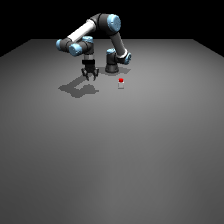

GT action [ 0.05        0.02477432 -0.00013083 -0.00134041 -0.00064942 -0.00105978
  0.        ]
Action: [ 0.03137255  0.         -0.00392157 -0.00079821 -0.00040517 -0.00018482
  0.        ]


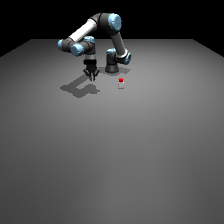

GT action [ 5.0000001e-02  2.4865223e-02  4.3848759e-05 -2.5131898e-03
 -1.3420547e-03 -1.0389957e-03  0.0000000e+00]
Action: [ 4.98039223e-02  3.33333338e-02  1.96078434e-03 -2.68960518e-03
 -1.13658298e-03 -5.91221098e-05  0.00000000e+00]


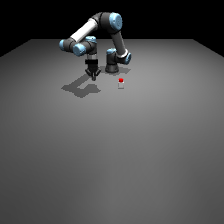

GT action [ 0.05        0.0249617   0.00021861 -0.0033887  -0.0018181  -0.00104002
  0.        ]
Action: [ 0.04980392  0.03333333  0.00627451 -0.00259734 -0.00173255 -0.00106473
  0.        ]


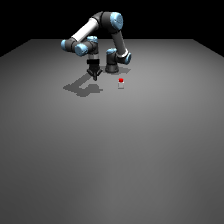

GT action [ 0.05        0.02506545  0.00039444 -0.00403347 -0.00212648 -0.00104068
  0.        ]
Action: [ 0.02470588  0.04980392  0.00392157 -0.00462714 -0.00232851 -0.00028957
  0.        ]


In [6]:
for step in range(1, 5):
        # TODO: Issue might be the prompt so this is just a placeholder now!
        prompt = "In: push the cube\nOut:"

        image_dict = df.loc[step,  'observation.images.Camera_rgb_image']
        image_bytes = image_dict['bytes']
        image = PIL.Image.open(io.BytesIO(image_bytes))
        display(image)

        # === BFLOAT16 MODE ===
        inputs = processor(prompt, image).to(device, dtype=torch.bfloat16)

        # === 8-BIT/4-BIT QUANTIZATION MODE ===
        # inputs = processor(prompt, image).to(device, dtype=torch.float16)

        # Run OpenVLA Inference
        action = vla.predict_action(**inputs, unnorm_key="pushbutton_mujoco_rlds", do_sample=False)
        print("GT action", df.loc[step, 'action'])
        print(f"Action: {action}")